In [23]:
import numpy as np
import naima as na
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c, m_e
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [24]:
#Luminosity distance
Lum_dist = 136 * u.Mpc

#Magnetic field    
B = 6.1e-2 * u.G
#Blob radius
R = 1e16 * u.cm
#Doppler factor
doppler_factor = 25

#Electron energy distribution parametrisation

##spectral parameters
gamma_min = 1e3
gamma_break = 2.1e5
gamma_max = 1.5e6
alpha_1 = 2.2
alpha_2 = 3.8
##energy density
u_e = 1.1e-2 * u.erg/(u.cm**3)


def gamma_to_E(gamma):

    E = gamma * (m_e*c**2).to(u.eV)

    return E

E_min = gamma_to_E(gamma_min)
E_break = gamma_to_E(gamma_break)
E_max = gamma_to_E(gamma_max)


spectrum_energy = np.logspace(-10, 20, 600)*u.eV



In [25]:
EDIS = na.models.BrokenPowerLaw(1*u.Unit('1/eV'), 1*u.eV, 
                                E_break, alpha_1, alpha_2)


In [26]:
#Synchrotron emission
SYN = na.models.Synchrotron(EDIS, B,
                            Eemin=E_min , Eemax=E_max)

SYN.set_We(u_e * (4/3) * np.pi * R**3, 
           Eemin=E_min, Eemax=E_max)


In [27]:
#Inverse Compton (IC) emission
##First, compute synchrotron photons density for IC process
Lsy = SYN.flux(spectrum_energy/doppler_factor, distance=0*u.cm)
phn_sy =  2.24*(spectrum_energy/doppler_factor)**2 *Lsy / (4 * np.pi * R**2 * c.to(u.cm/u.s) ) 


##IC flux computation
IC = na.models.InverseCompton(EDIS, 
                              seed_photon_fields=[['SSC', spectrum_energy/doppler_factor, phn_sy]], 
                              Eemin=E_min , 
                              Eemax=E_max)

IC.set_We(u_e * (4/3) * np.pi * R**3, 
          Eemin=E_min, Eemax=E_max)


In [28]:
obs_flux_SYN = doppler_factor**4 * (spectrum_energy/doppler_factor)**2 * SYN.flux(spectrum_energy/doppler_factor, distance=0 * u.Mpc) / (4 * np.pi * ((Lum_dist).to(u.cm) )**2)

obs_flux_IC = doppler_factor**4 * (spectrum_energy/doppler_factor)**2 * IC.flux(spectrum_energy/doppler_factor, distance=0 * u.Mpc) / (4 * np.pi * ((Lum_dist).to(u.cm) )**2)


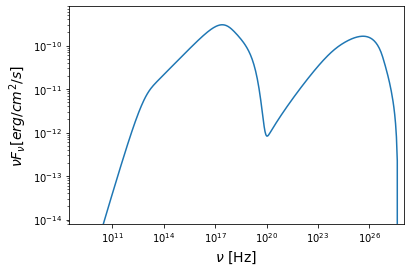

In [29]:
plt.plot(spectrum_energy.to(u.Hz, equivalencies=u.spectral()), (obs_flux_SYN+obs_flux_IC).to(u.erg*u.cm**(-2)*u.s**(-1)), '-')

plt.xscale('log')
plt.yscale('log')

plt.xlim(3e8, 1e28)
plt.ylim(8e-15, 8e-10)

plt.xlabel(r'$\nu$ [Hz]', fontsize=14)
plt.ylabel(r'$\nu F_{\nu} [erg/cm^2/s]$', fontsize=14)

plt.show()